In [23]:
import json
import os
import typing
from collections import defaultdict, namedtuple
from typing import Type

import einops
import numpy as np
import pandas as pd
import torch as t
from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce
from devinterp.vis_utils import EpsilonBetaAnalyzer
from devinterp.utils import plot_trace

from jaxtyping import Float
from torch import Tensor, nn
from torch.utils.data import DataLoader, random_split

import wandb
from pizza_clock.config import get_device
from pizza_clock.dataset import AdditionDataset
from pizza_clock.metrics import compute_gradient_similarity
from pizza_clock.training import ModularAdditionModelTrainer
from pathlib import Path
from pizza_clock.dataset import get_train_val_data
from pizza_clock.config import Config
from functools import partial
from torch.nn import functional as F




In [ ]:
def evaluate_last_position(criterion, model, data):
    x, y = data
    out = model(x)
    logits = out[:, -1, :]  # Get the last position's logits: [batch, vocab]
    return criterion(logits, y), {"output": logits}

evaluate_last_position_ce = partial(evaluate_last_position, F.cross_entropy)


def estimate_llc_given_model(
    model: t.nn.Module,
    loader: t.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[t.optim.Optimizer] = SGLD,
    localization: float = 5.0,
    num_chains: int = 2,
    num_draws: int = 500,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: t.device = get_device(),
    online: bool = True,
    verbose: bool = False,
):
    # Copied from devinterp grokking notebook https://github.com/timaeus-research/devinterp/blob/main/examples/grokking.ipynb
    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats

def load_model_and_config(dir_path: str):
    config_json = json.load(open(f"{dir_path}/config.json", "r"))
    config = Config(**config_json)
    final_model = t.load(f"{dir_path}/final_model.pt", map_location=get_device(), weights_only=False)
    all_models = [
        t.load(f"{dir_path}/model_{i}.pt", map_location=get_device(), weights_only=False)
        for i in range(len(list(Path(dir_path).glob("model_*.pt"))))
    ]
    return final_model, config, all_models

In [ ]:
dir_path = "saved_models/2026-01-27/attn0.0_seed4"
final_model, config, all_models = load_model_and_config(dir_path)
train_loader, _ = get_train_val_data(config, squeeze_targets=True)

analyzer = EpsilonBetaAnalyzer()
analyzer.configure_sweep(
    llc_estimator=estimate_llc_given_model,
    llc_estimator_kwargs=dict(
        model=final_model,
        evaluate=evaluate_last_position_ce,  # Use custom evaluate function
        device=get_device(),
        loader=train_loader,
    ),
    min_epsilon=3e-7,
    max_epsilon=3e-4, # I got nans above 3e-4
    epsilon_samples=5,
    min_beta=None,
    max_beta=None,
    beta_samples=5,
    dataloader=train_loader,
)
analyzer.sweep()

 16%|█▌        | 4/25 [00:50<04:22, 12.51s/it]


KeyboardInterrupt: 

In [17]:
analyzer.plot(div_out_beta=True)

In [18]:
analyzer = EpsilonBetaAnalyzer()
analyzer.configure_sweep(
    llc_estimator=estimate_llc_given_model,
    llc_estimator_kwargs=dict(
        model=final_model,
        evaluate=evaluate_last_position_ce,  # Use custom evaluate function
        device=get_device(),
        loader=train_loader,
        num_chains=5,
        num_draws=2000,
    ),
    min_epsilon=3e-7,
    max_epsilon=3e-4, # I got nans above 3e-4
    epsilon_samples=5,
    min_beta=None,
    max_beta=None,
    beta_samples=5,
    dataloader=train_loader,
)
analyzer.sweep()

  0%|          | 0/25 [00:00<?, ?it/s]/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning:

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning:

You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning:

You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] 

In [20]:
analyzer.plot(div_out_beta=True)

In [27]:
def estimate_and_plot_llc(lr =1e-5, nbeta=10.0, localization=10.0, num_chains=3, num_draws=1500):

    learning_coeff_stats = estimate_learning_coeff_with_summary(
        final_model,
        loader=train_loader,
        evaluate=evaluate_last_position_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=localization),
        num_chains=num_chains,
        num_draws=num_draws,
        device=get_device(),
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    plot_trace(
        trace,
        "Loss",
        x_axis="Step",
        title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning:

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning:

You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning:

You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)

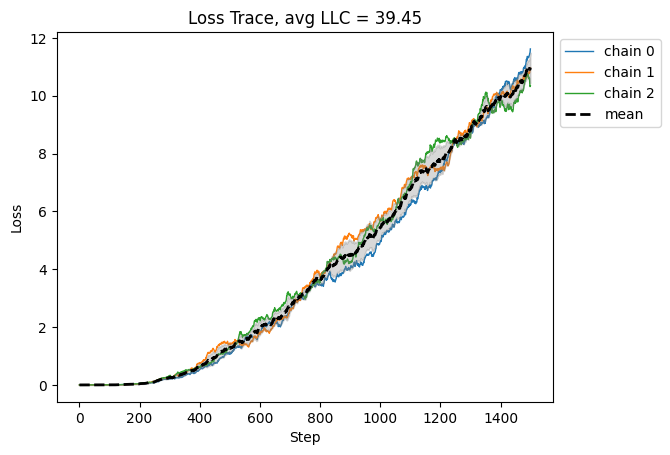

<Figure size 1200x900 with 0 Axes>

In [28]:
estimate_and_plot_llc()

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning:

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning:

You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning:

You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)

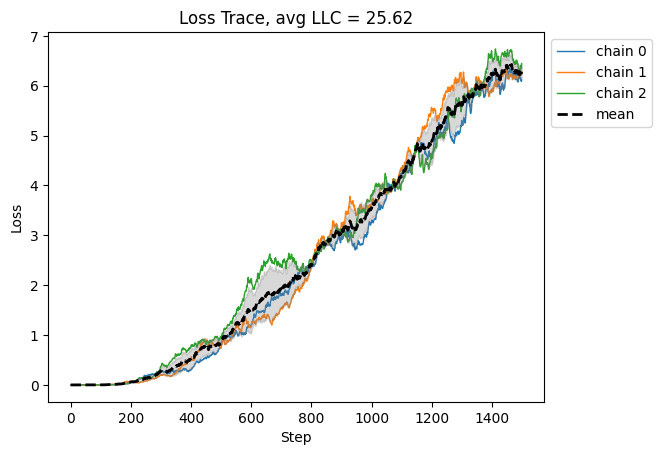

<Figure size 1200x900 with 0 Axes>

In [29]:
estimate_and_plot_llc(localization=50.0, lr=1e-5)


In [ ]:
es